# Logistic Regression

This notebook covers the solution to the third question in assignment 1 of CMPE462.

Before diving into the questions, we will first load the data:

In [1]:
DATA_DIR = "data/logisticRegression_data"

import numpy as np

def load_npy_file(file_name: str) -> np.array:
    return np.load(f"{DATA_DIR}/{file_name}")

X_train = load_npy_file("train_data.npy")
y_train = load_npy_file("train_labels.npy")
X_test = load_npy_file("test_data.npy")
y_test = load_npy_file("test_labels.npy")

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1561, 256), (1561,), (424, 256), (424,))

Checking the range of values in different datasets:

In [2]:
value_range = lambda X: (X.min(), X.max())
print(value_range(X_train))
print(value_range(X_test))

(-1.0, 1.0)
(-1.0, 1.0)


First, we will transform the data into squares and view a few samples. Reshape the data:

In [3]:
X_train_square = X_train.reshape(1561, 16, 16)
X_test_square = X_test.reshape(424, 16, 16)

Plot some samples:

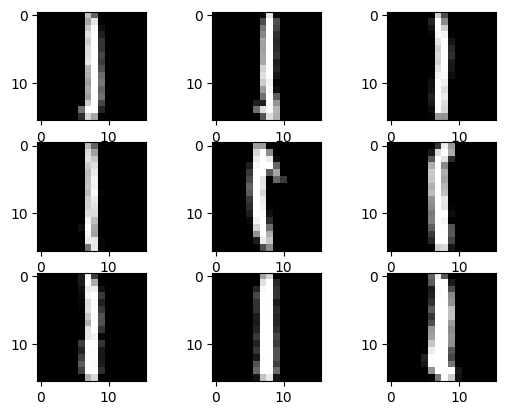

In [4]:
import matplotlib.pyplot as plt

def plot_samples(X: np.array, d: int = 3):
    fig, ax = plt.subplots(d,d)
    ax = ax.flatten()
    for i, _ax in enumerate(ax):
        _ax.imshow(X[i], cmap="gray")
    plt.show()

plot_samples(X_train_square)

Plot some 5 samples:

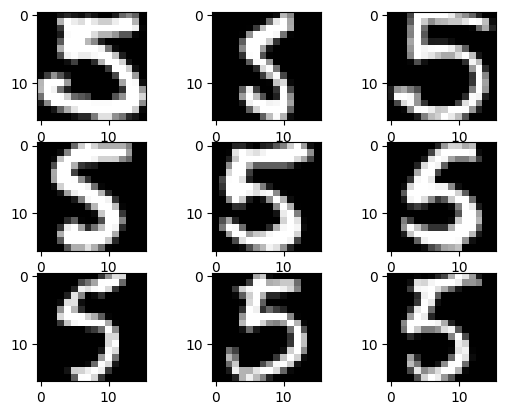

In [5]:
plot_samples(X_train_square[y_train == -1])

# (a): Extract Two Features

In the first question, we will extract two features to distinguish 1 and 5s:

> Extract the two features discussed in the class (symmetry and average intensity) to distinguish 1 and 5.

We implement the functions for transforming the dataframes into symmetry and average intensity features.

Average intensity is simply taking the mean of the second and thirds axis:

In [6]:
def transform_to_average_intensity(X):
    X = X.copy()
    X = (X + 1) / 2
    return np.mean(X, axis=(1,2))

To calculate the symmetry, we will need to 'flip' the digits. We can make use of the `np.flip` method:

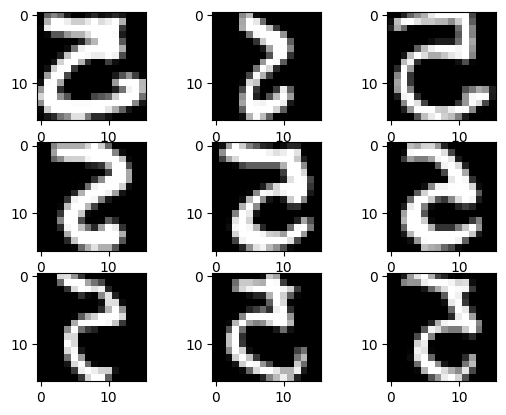

In [7]:
plot_samples(np.flip(X_train_square[y_train == -1], axis=2))

Here is the function for calculating the symmetry feature:

In [8]:
def transform_to_symmetry(X):
    return - np.mean(np.abs(X - np.flip(X , axis=2)), axis=(1,2))

Finally, we use the methods we wrote and transform our data from shape `(n_samples, 16, 16)` to `(n_samples, 2)`:

In [9]:
def transform(X):
    X_average_intensity = transform_to_average_intensity(X)
    X_symmetry = transform_to_symmetry(X)

    return np.stack([X_average_intensity, X_symmetry], axis=1)

X_train_transformed = transform(X_train_square)
X_test_transformed  = transform(X_test_square)

X_train_transformed.shape

(1561, 2)

# (b): Plot features with scatter plot

In the second question, we will plot the new data with a scatter plot:

> Provide 2-D scatter plots of your features for training and test data (Now your data matrix will be N×2). For each data example, plot the two features with a red × if it is a 5 and a blue ◦ if it is a 1.

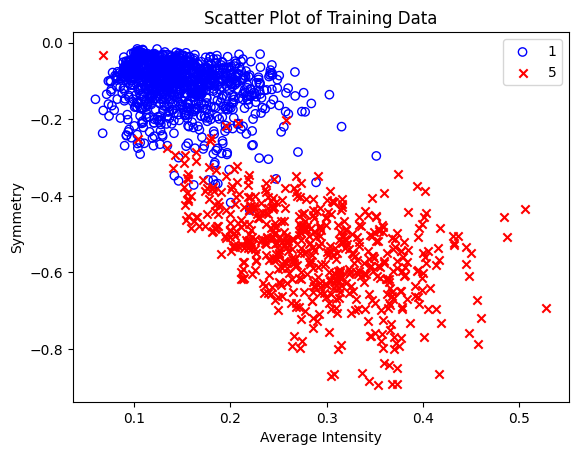

In [10]:
def plot_scatter(X, y, title=None, show=True):

    # scatter plot 1s
    plt.scatter(
        x=X[y==1, 0],
        y=X[y==1, 1],
        marker="o",
        facecolors='none', edgecolors='blue',
        label="1"
    )

    # scatter plot 5s
    plt.scatter(
        x=X[y==-1, 0],
        y=X[y==-1, 1],
        marker="x",
        color="red",
        label="5"
    )

    plt.xlabel("Average Intensity")
    plt.ylabel("Symmetry")
    plt.legend()

    plt.title(title)
    if show:
        plt.show()

plot_scatter(X_train_transformed, y_train, "Scatter Plot of Training Data")

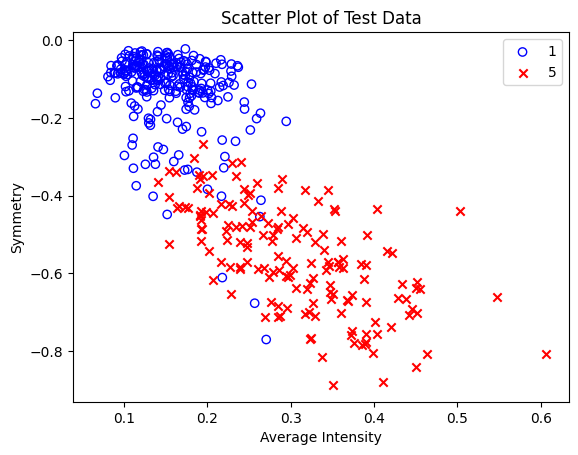

In [11]:
plot_scatter(X_test_transformed, y_test, "Scatter Plot of Test Data")

# (c) Logistic Regression

In the third question, we are asked to implement logistic regression classifier from stratch:

> Please write the expression of the gradient of the logistic loss. Implement logistic regression classifier from scratch. Give separate plots of the training and test data, together with the separators. Report train Ein and test Etest errors with train and test classification accuracies.

We implement the `LogisticRegression` class below. It has the following methods:
- `logistic_loss`: Calculates the logistic loss as:
  
  $$
  E(w) = \frac{1}{N} * \sum\limits_{n=1}^N ln(1 + exp(-y_nw^Tx_n))
  $$
- `logistic_loss_gradient`: Calculates the gradient according the logistic loss as:
  
  $$
  g_t = - \frac{1}{N} * \sum\limits_{n=1}^N \frac{y_nx_n}{1 + exp(y_nw^T(t)x_n)}
  $$
- `train`: Runs the gradient decent algorithm by computing the gradient and updating weights in each epoch.
- `predict`: Calculate label with:

  $$
  y' = \frac{1}{1+exp(-w^Tx)}
  $$
- `plot_loss_curve`: Plot the loss values recorded during training
- `plot_decision_boundary`: Plot decision boundary. Can only be used if the dataset is two dimensional. 
  
  Decision boundary line is found with the following method:
  $$
  \theta(w^Tx) = 0.5 \\
  \frac{1}{1+e^{-w^Tx}} = 0.5 \\
  1+e^{-w^Tx} = 2 \\
  e^{-w^Tx} = 1 \\
  -w^Tx = ln(1) \\
  -w^Tx = 0 \\
  w^Tx = 0 \\
  w_0 + w_1 x_0 + w_2 x_1 = 0 \\
  x_1 = - \frac{w_0 + w_1 x_0}{w_2} \\
  $$

  We can then replace $x_0$ and $x_1$ with $x$ and $y$:
  
  $$
  y = - \frac{w_0 + w_1 x}{w_2} \\
  $$

  We find the offset and the slope from the equation above and draw the decision boundary.

In [12]:
from typing import Tuple, Optional

class LogisticRegression:

    def __init__(self, input_shape: int):
        self.input_shape = input_shape
        self.w = np.ones(input_shape + 1, dtype="float64") / 2

        self._train_losses = list()
        self._test_losses = list()
        self._epochs = None
    
    def logistic_loss(self, X: np.array, y: np.array) -> float:
        """
        We are using the following numpy methods:
        - np.exp: natural exponential
        - np.multiply: element-wise multiplication
        - np.matmul: matrix multiplication
        """
        X = self._pad_X(X)
        inner_result = 1 + np.exp(np.multiply(-y, np.matmul(X, self.w)))
        assert inner_result.shape == y.shape
        return np.log(inner_result).mean()

    def logistic_loss_gradient(self, X: np.array, y: np.array) -> np.array:
        """
        see page 95 in "Learning From Data"
        """
        X = self._pad_X(X)
        nominator = X * y[:, np.newaxis]
        denominator = 1 + np.exp(np.multiply(y, np.matmul(X, self.w)))
        return - np.divide(nominator, denominator[:, np.newaxis]).mean(axis=0)
    
    def train(
            self,
            X: np.array,
            y: np.array,
            epochs: int,
            learning_rate: float,
            eval_set: Tuple[np.array, np.array] = None,
            verbose: bool = True,
            print_every: int = 10
    ):
            
        self._epochs = range(1, epochs+1)

        for epoch in self._epochs:
            # compute gradient
            gradient = self.logistic_loss_gradient(X, y)

            # update weights
            direction = - gradient
            self.w = self.w + learning_rate * direction

            # log losses
            train_loss = self.logistic_loss(X, y)
            self._train_losses.append(train_loss)            
            if eval_set:
                test_loss = self.logistic_loss(*eval_set)
                self._test_losses.append(test_loss)
            else:
                test_loss = None

            # print epoch results
            if verbose and (epoch%print_every==0 or epoch==epochs):
                print(f"epoch {epoch} - train_loss: {train_loss}", end="")
                print(f" test_loss: {test_loss}" if test_loss else "")

    def predict(
            self,
            X,
            threshold: Optional[float] = None,
            positive_label: int = 1,
            negative_label: int = -1
    ):
        """
        matrix multiplication and sigmoid

        X is the data to predict.

        If threshold is provided, then the predictons
        are thresholded and they are assigned to positive_label
        or negative_label.
        """
        X = self._pad_X(X)
        results = 1/(1 + np.exp( - np.matmul(X, self.w)))
        if threshold:
            idx = results < threshold
            results[idx] = negative_label
            results[~idx] = positive_label
        return results
    
    def plot_loss_curve(self):
        plt.plot(self._epochs, self._train_losses, label="Training")
        if self._test_losses:
            plt.plot(self._epochs, self._test_losses, label="Testing")
        plt.legend()
        plt.show()

    def plot_decision_boundary(self, X, show=True):
        slope = - self.w[1] / self.w[2]
        offset = - self.w[0] / self.w[2]
        
        # get the minimum and maximum x values from the data
        x = [X[:, 0].min(), X[:, 0].max()]
        y = [offset + _x * slope for _x in x]
        
        plt.plot(x, y, "g--", label="Decision Boundary")
        
        if show:
            plt.show()

    @classmethod
    def _pad_X(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))

Next, we use our Logistic Regression implementation to train a model for the data with two features:

epoch 10 - train_loss: 0.2971204577425457 test_loss: 0.3147069997134763
epoch 20 - train_loss: 0.20514973437699854 test_loss: 0.23365859172911999
epoch 30 - train_loss: 0.16322759364505401 test_loss: 0.19931120927693358
epoch 40 - train_loss: 0.1392196036517249 test_loss: 0.18084862155597864
epoch 50 - train_loss: 0.12361689450153282 test_loss: 0.16956218318095637


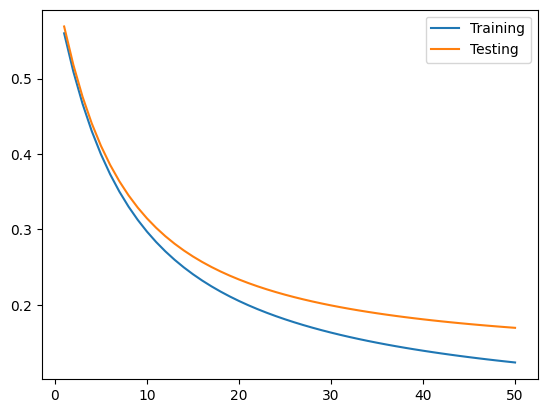

In [13]:
lr = LogisticRegression(2)
lr.train(X_train_transformed, y_train, 50, 7, eval_set=(X_test_transformed, y_test))
lr.plot_loss_curve()

Plotting train and test data with seperators:

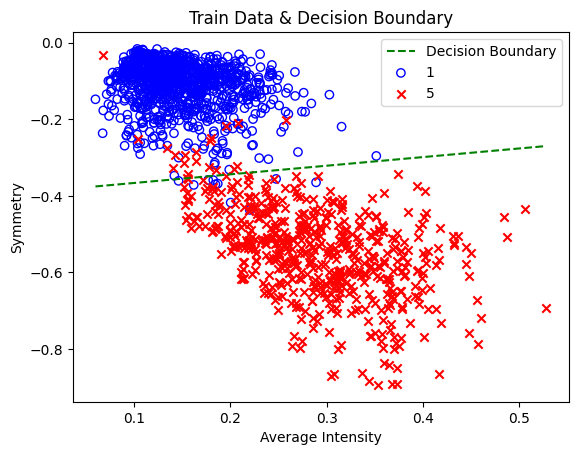

In [14]:
lr.plot_decision_boundary(X_train_transformed, show=False)
plot_scatter(X_train_transformed, y_train, show=False)
plt.title("Train Data & Decision Boundary")
plt.show()

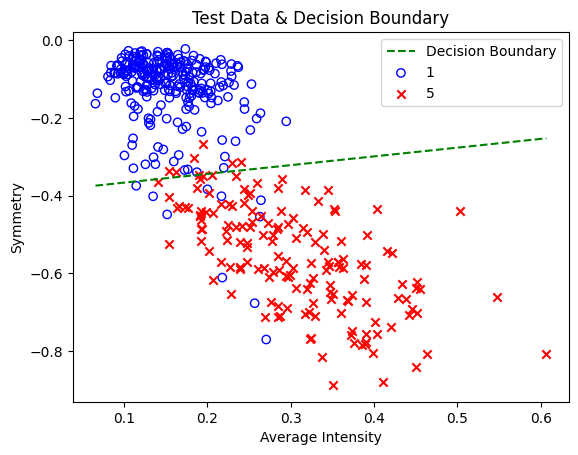

In [15]:
lr.plot_decision_boundary(X_test_transformed, show=False)
plot_scatter(X_test_transformed, y_test, show=False)
plt.title("Test Data & Decision Boundary")
plt.show()

Train and test error and accuracies:

In [16]:
print(f"Train error: {lr._train_losses[-1]}, Test Error: {lr._test_losses[-1]}")

accuracy = lambda X, y: sum(y == lr.predict(X, threshold=0.5)) / len(y) * 100
print(f"Train accuracy: {accuracy(X_train_transformed, y_train)},"
      f" Test Accuracy: {accuracy(X_test_transformed, y_test)}")

Train error: 0.12361689450153282, Test Error: 0.16956218318095637
Train accuracy: 98.07815502882768, Test Accuracy: 95.99056603773585


# (d) Regularized Logistic Regression

In the final question, we are asked to implement a regularized logistic regression:

> Train a regularized logistic regression: $min_w E(w) + λ||w||^2_2$, where E(w) is the logistic loss. Change your gradient descent algorithm accordingly and train a regularized model. This time, do not extract symmetry and average intensity features but use flattened images as your input vector. Report the best λ using cross-validation. Report train and test classification accuracies. Did regularization improve the performance in the case of using the raw images as inputs? Discuss.

To answer this question, we will first train a normal (without regularization) logistic regression with the raw image data to set the baseline.

epoch 10 - train_loss: 21.834875185347073 test_loss: 20.561031022045967
epoch 20 - train_loss: 1.0520883526344171 test_loss: 1.3933113395219525
epoch 30 - train_loss: 0.46172011286724307 test_loss: 0.9047791068430939
epoch 35 - train_loss: 0.3922657551892463 test_loss: 0.8218528751394102


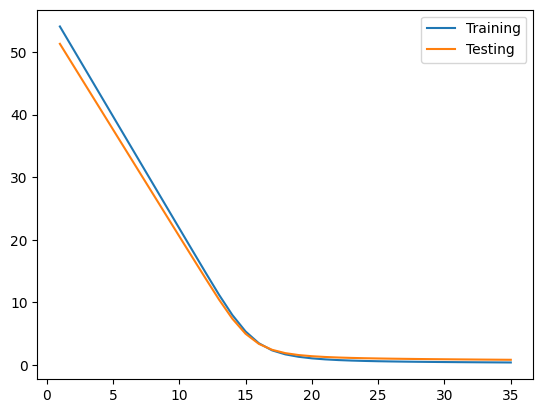

In [17]:
lr = LogisticRegression(16*16)
lr.train(X_train, y_train, 35, 0.04, eval_set=(X_test, y_test))
lr.plot_loss_curve()

In [18]:
print(f"Train error: {lr._train_losses[-1]}, Test Error: {lr._test_losses[-1]}")

accuracy = lambda X, y: sum(y == lr.predict(X, threshold=0.5)) / len(y) * 100
print(f"Train accuracy: {accuracy(X_train, y_train)},"
      f" Test Accuracy: {accuracy(X_test, y_test)}")

Train error: 0.3922657551892463, Test Error: 0.8218528751394102
Train accuracy: 91.22357463164637, Test Accuracy: 87.26415094339622


Now that we have the baseline, we will now implement the Regularized Logistic Regresson. To Implement the regularized version, we simply subclass the `LogisticRegression` class and overwrite the `logistic_loss` and `logistic_loss_gradient` methods. In both these methods, we call the previous versions but also add the regularization term or its derivative.

In [19]:
class RegularizedLogisticRegression(LogisticRegression):

    def __init__(self, input_shape, regularization_coefficient):
        super().__init__(input_shape)
        self.regularization_coefficient = regularization_coefficient

    def logistic_loss(self, X, y):
        loss = super().logistic_loss(X, y)
        return loss + self.regularization_coefficient * (np.linalg.norm(self.w) ** 2)

    def logistic_loss_gradient(self, X, y):
        gradient = super().logistic_loss_gradient(X, y)
        gradient += self.regularization_coefficient * 2 * self.w
        return gradient

epoch 10 - train_loss: 9.023768087021972 test_loss: 8.809756691439643
epoch 20 - train_loss: 1.6631134334591369 test_loss: 1.7708296312466016
epoch 30 - train_loss: 0.5672013103731531 test_loss: 0.6155046467012526
epoch 35 - train_loss: 0.40015296828572067 test_loss: 0.43609596060748773


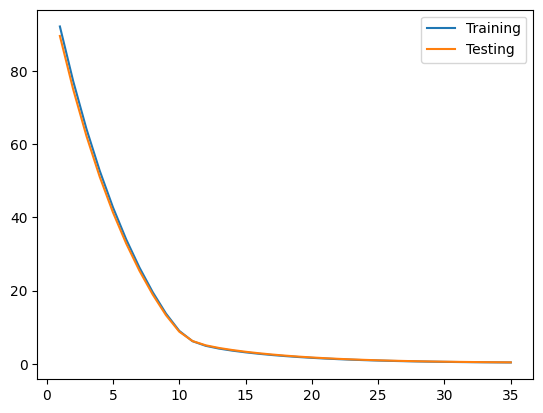

In [20]:
rlr = RegularizedLogisticRegression(16*16, 0.8)
rlr.train(X_train, y_train, 35, 0.04, eval_set=(X_test, y_test))
rlr.plot_loss_curve()

In [21]:
print(f"Train error: {rlr._train_losses[-1]}, Test Error: {rlr._test_losses[-1]}")

accuracy = lambda model, X, y: sum(y == model.predict(X, threshold=0.5)) / len(y) * 100
print(f"Train accuracy: {accuracy(rlr, X_train, y_train)},"
      f" Test Accuracy: {accuracy(rlr, X_test, y_test)}")

Train error: 0.40015296828572067, Test Error: 0.43609596060748773
Train accuracy: 99.10313901345292, Test Accuracy: 96.69811320754717


We observe that the regularized logistic regression out-performs the non-regularized logistic regression. Test accuracy improved from 87.26 to 96.69.

We will use K-Fold cross-validation to report an optimal regularization coefficient. We will split the training data into `n` sets. Then for each set `i`, a regularized logistic regression model with `regularization_coefficient = k` using all the sets except set `i`. Model of each fold will be scored using the set `i` and mean of the scores will be reported as the average score of `regularization_coefficient = k`. This will take place for a range of possible `regularization_coefficient` values to report the ideal coefficient value.

In [22]:
# - params -
resolution = 20  # Number of candidate coefficients to try
number_of_folds = 5  # number of folds in K-fold

# - k-folds algorithm -
candidate_coefficients = [i/resolution*2 for i in range(resolution)]

def get_folds(X, y, number_of_folds):
    """Iterator generating folds"""
    
    # shuffle data
    idx = np.random.permutation(X.shape[0])
    X, y = X[idx], y[idx]

    fold_size = int(X.shape[0] // number_of_folds)
    for i in range(number_of_folds):
        seperator_1 = i*fold_size
        seperator_2 = (i+1)*fold_size
        
        fold_X_train = np.concatenate((X[:seperator_1], X[seperator_2:]))
        fold_y_train = np.concatenate((y[:seperator_1], y[seperator_2:]))
        fold_X_val = X[seperator_1: seperator_2]
        fold_y_val = y[seperator_1: seperator_2]

        yield fold_X_train, fold_y_train, fold_X_val, fold_y_val

coef_train_acc_means, coef_val_acc_means = [], []  # list to hold mean accuracy of each coefficient value
for coefficient in candidate_coefficients:
    fold_train_acc, fold_val_acc = [], []  # lists to hold accuracy of each fold
    for fold_data in get_folds(X_train, y_train, number_of_folds):
        fold_X_train, fold_y_train, fold_X_val, fold_y_val = fold_data

        # init a model for each fold and train it
        rlr = RegularizedLogisticRegression(16*16, coefficient)
        rlr.train(fold_X_train, fold_y_train, 35, 0.04, verbose=False)

        # save accuracy
        fold_train_acc.append(accuracy(rlr, fold_X_train, fold_y_train))
        fold_val_acc.append(accuracy(rlr, fold_X_val, fold_y_val))
        
    # save mean of  every fold
    coef_train_acc_means.append(sum(fold_train_acc) / number_of_folds)
    coef_val_acc_means.append(sum(fold_val_acc) / number_of_folds)

Finally, we plot the accuracy against regularization coefficient:

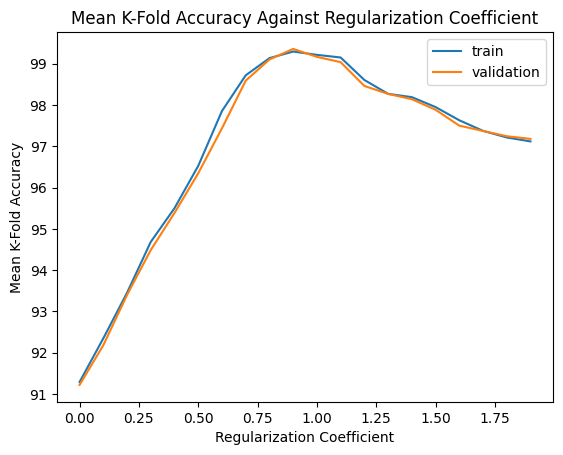

In [23]:
plt.plot(candidate_coefficients, coef_train_acc_means, label="train")
plt.plot(candidate_coefficients, coef_val_acc_means, label="validation")
plt.xlabel("Regularization Coefficient")
plt.ylabel("Mean K-Fold Accuracy")
plt.title("Mean K-Fold Accuracy Against Regularization Coefficient")
plt.legend()
plt.show()

We observe that choosing a value around 0.9 - 1.0 results in maximum K-Fold accuracy.